<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-временным-рядам" data-toc-modified-id="Вывод-по-временным-рядам-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по временным рядам</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подгружаем библиотеки и загружаем данные

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,mean_squared_error
from lightgbm import LGBMRegressor
RND_ST = 12345
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
pth = '/datasets/taxi.csv'
if os.path.exists(pth):
    df = pd.read_csv(pth, parse_dates=['datetime'], dayfirst = True, index_col=['datetime'])
else:
    print('Путь не таков')

## Анализ

Получаем всю необходимую информацию

In [3]:
def info_func(df):
    print('Общая информация')
    print('')
    print(df.info())
    print('')
    print(df.describe())
    print('')
    for column in df.columns:
        print('Уникальные значения столбца', column)
        print('')
        print(df[column].unique())
        print('')
    print('Кол-во строк дубликатов')
    print('')
    print(df[df.duplicated()].count().sort_values(ascending=False))
    print('')
    print('Кол-во пропущенных значений')
    print('')
    print(df.isna().sum().sort_values(ascending=False))
    print('')
    print('Процент пропущенных значений')
    print('')
    print((df.isna().sum()/len(df)*100).sort_values(ascending=False))
    print('')
    print(df.head(-5))

Делаем ресемплирование по часу

In [4]:
df = df.resample('1H').sum()

In [5]:
info_func(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Уникальные значения столбца num_orders

[124  85  71  66  43   6  12  15  34  69  64  96  30  32  48  44  73  45
  61 113  58  90 120  75  20  11   7  46  54  91  36  59  82  83  89  49
  93 101 119  72 163 108  25   9  17  56  52  57  28  41  76  68  63  60
  26  42  27  22  39  19  51  80  77  86 176  16   3  14  31  50  62  37
  40  47  10  81 100 121  24  38  55  99 127  94 143  78  65  97 114  88
  79  84  29   1   4  70 117   5  18  53 102  33 107 118 153 105  67  35
 109  21   8 123 110

Дубликаты в num_orders вполне могут быть, тут ничего необычного нет

Строим график с разбивкой по часу

<AxesSubplot:xlabel='datetime'>

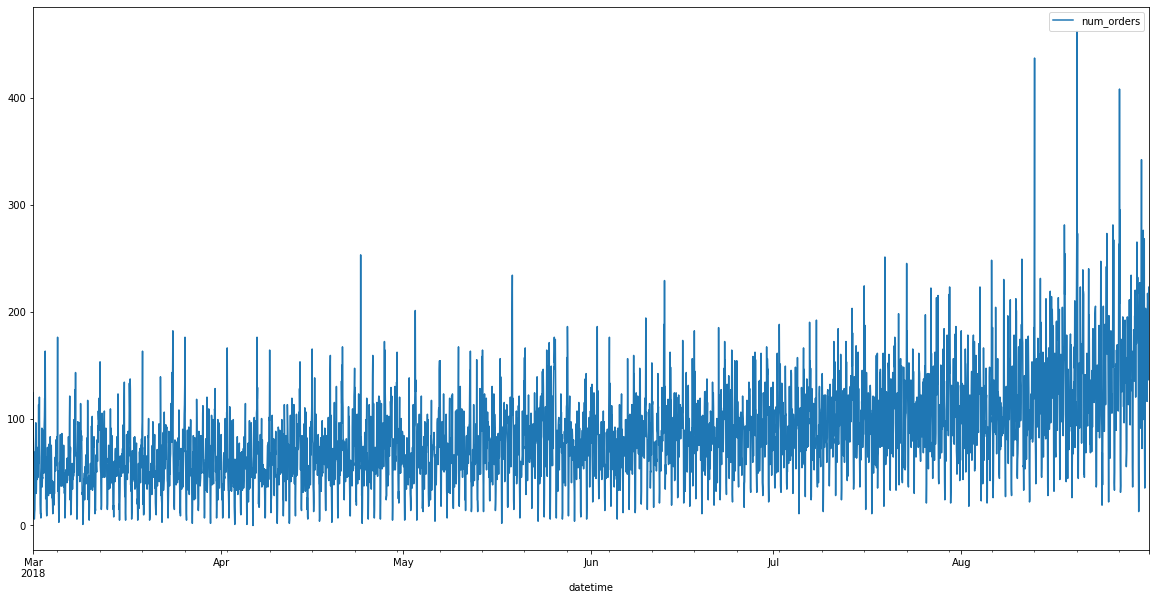

In [6]:
figsize = (20,10)
df.plot(figsize=figsize)

Особо ничего не понятно, поэтому возьмем последнюю неделю

<AxesSubplot:xlabel='datetime'>

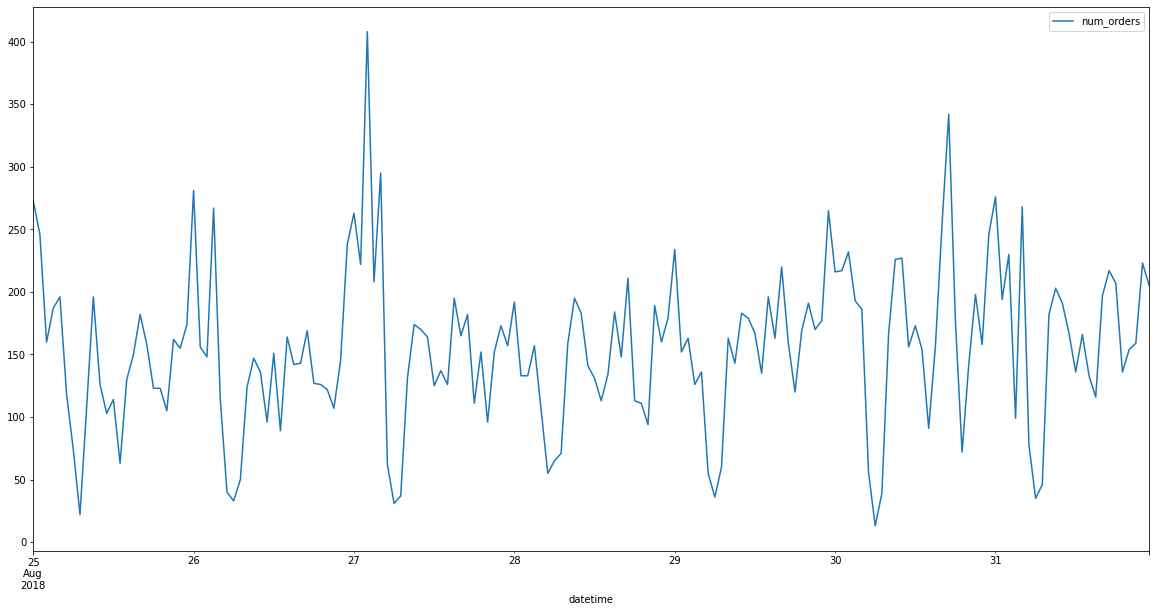

In [7]:
df['2018-08-25':'2018-08-31'].plot(figsize=figsize)

Заполночь становится заметно меньше заказов

Строим графики, чтобы посмотреть на тренды, сезонность, остаток декомпозиции

Text(0.5, 1.05, 'Тренд за все время')

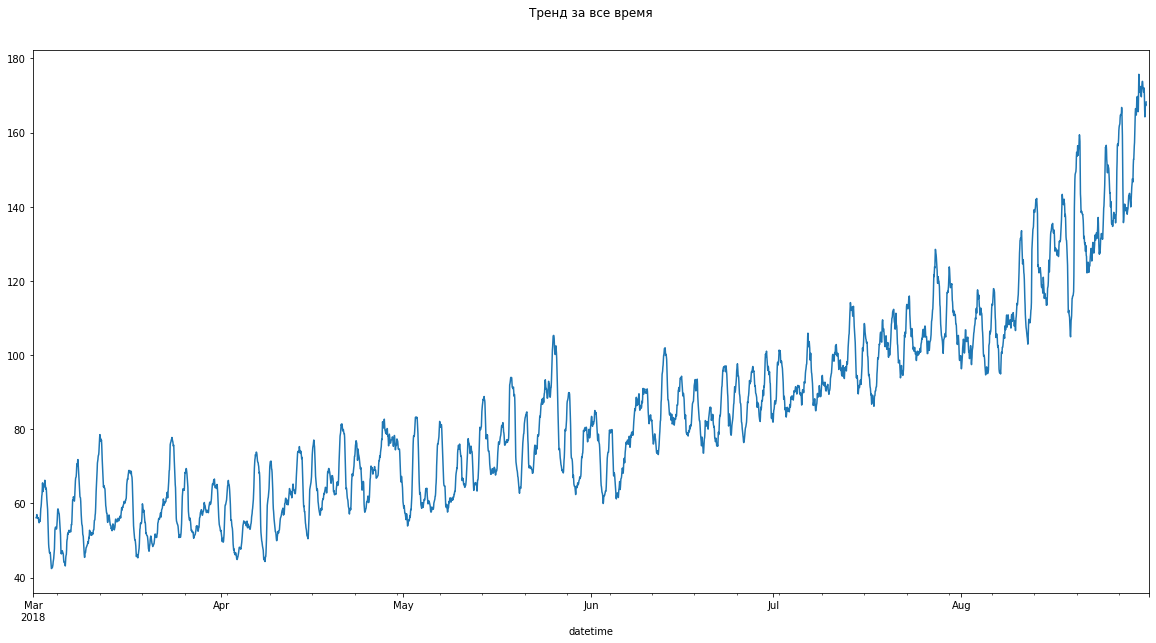

In [8]:
decomposed_df = seasonal_decompose(df)
decomposed_df_week = seasonal_decompose(df['2018-08-25':'2018-08-31'])
decomposed_df.trend.plot(figsize=figsize)
plt.title('Тренд за все время', y=1.05)

Text(0.5, 1.05, 'Сезонность за все время')

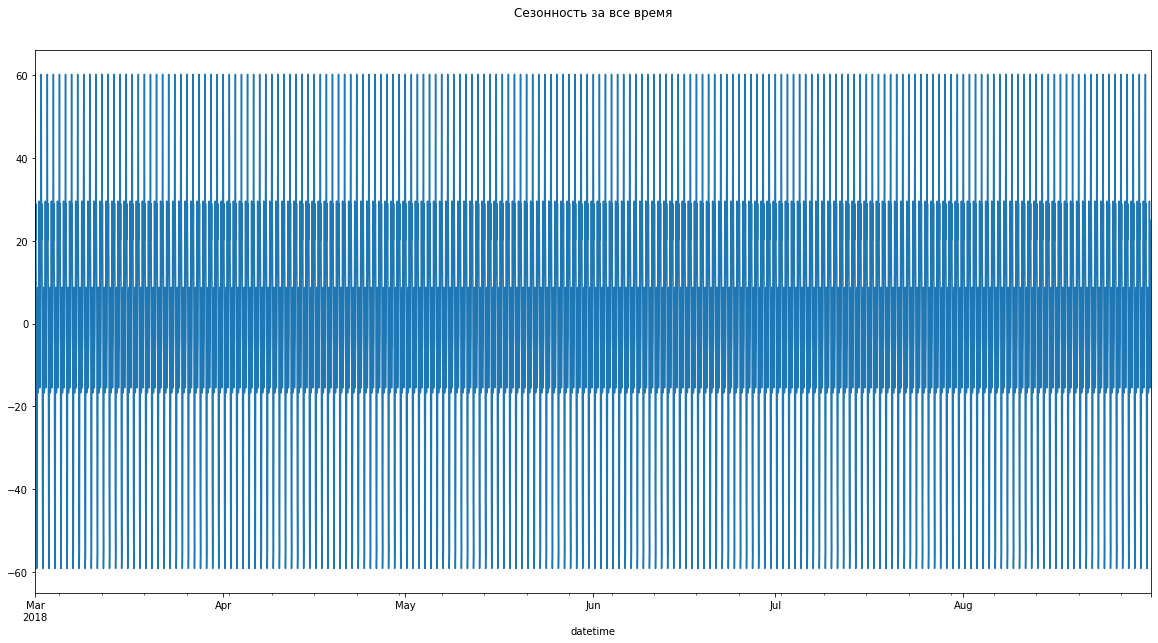

In [9]:
decomposed_df.seasonal.plot(figsize=figsize)
plt.title('Сезонность за все время', y=1.05)

Text(0.5, 1.05, 'Сезонность за последнюю неделю')

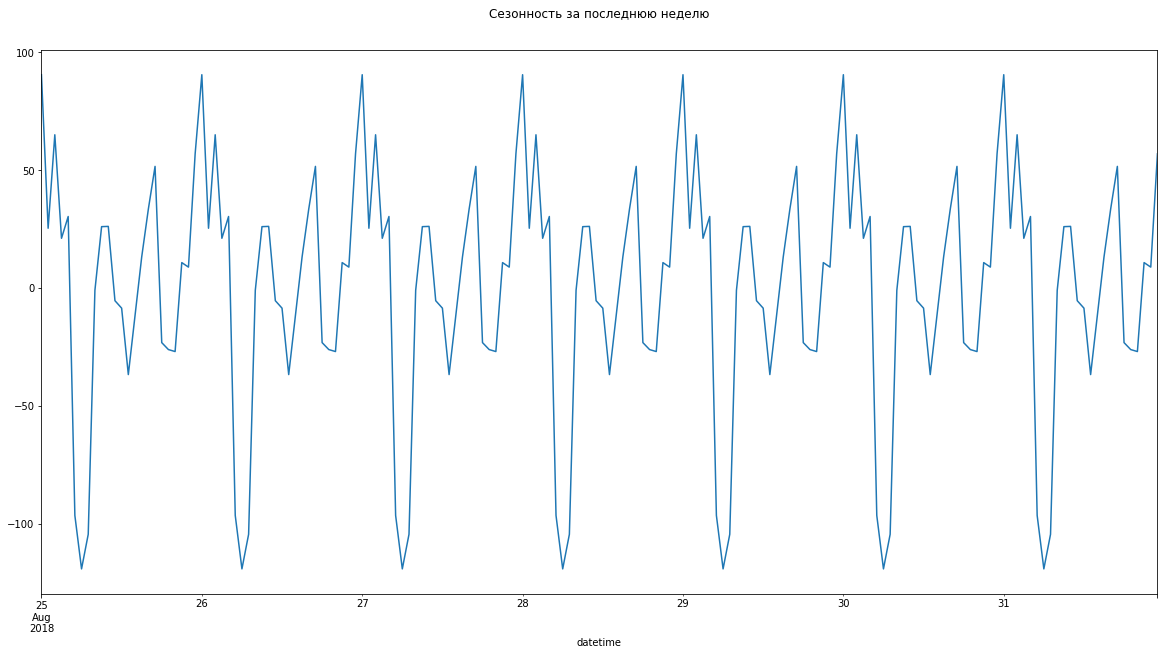

In [10]:
decomposed_df_week.seasonal.plot(figsize=figsize)
plt.title('Сезонность за последнюю неделю', y=1.05)

Text(0.5, 1.05, 'Остатки за все время')

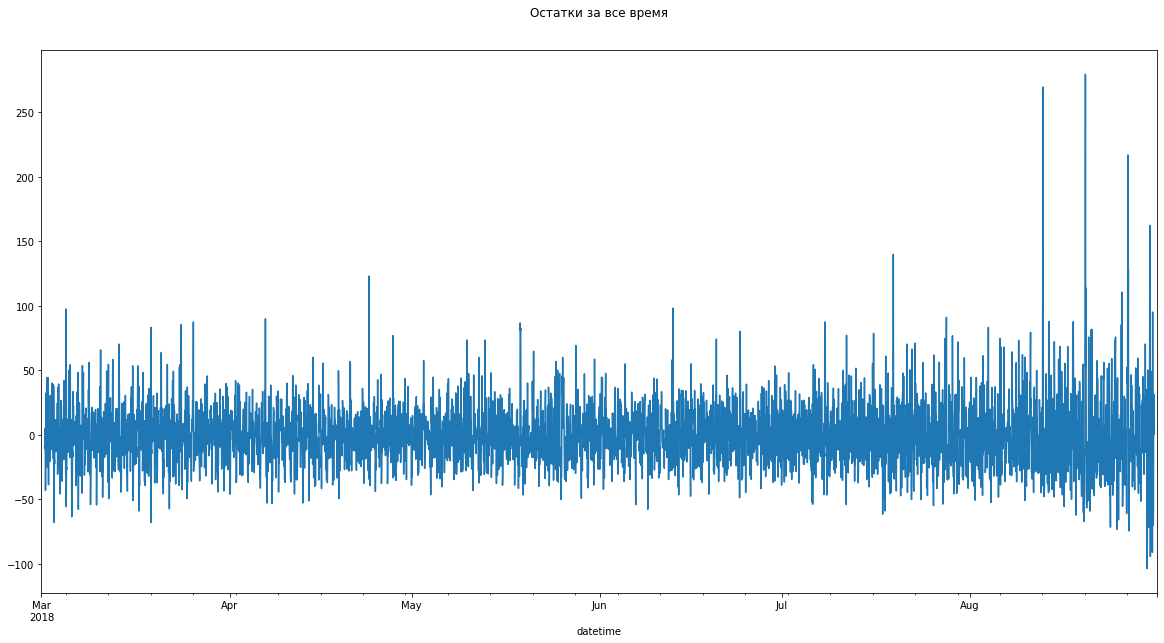

In [11]:
decomposed_df.resid.plot(figsize=figsize)
plt.title('Остатки за все время', y=1.05)

Text(0.5, 1.05, 'Остатки за последнюю неделю')

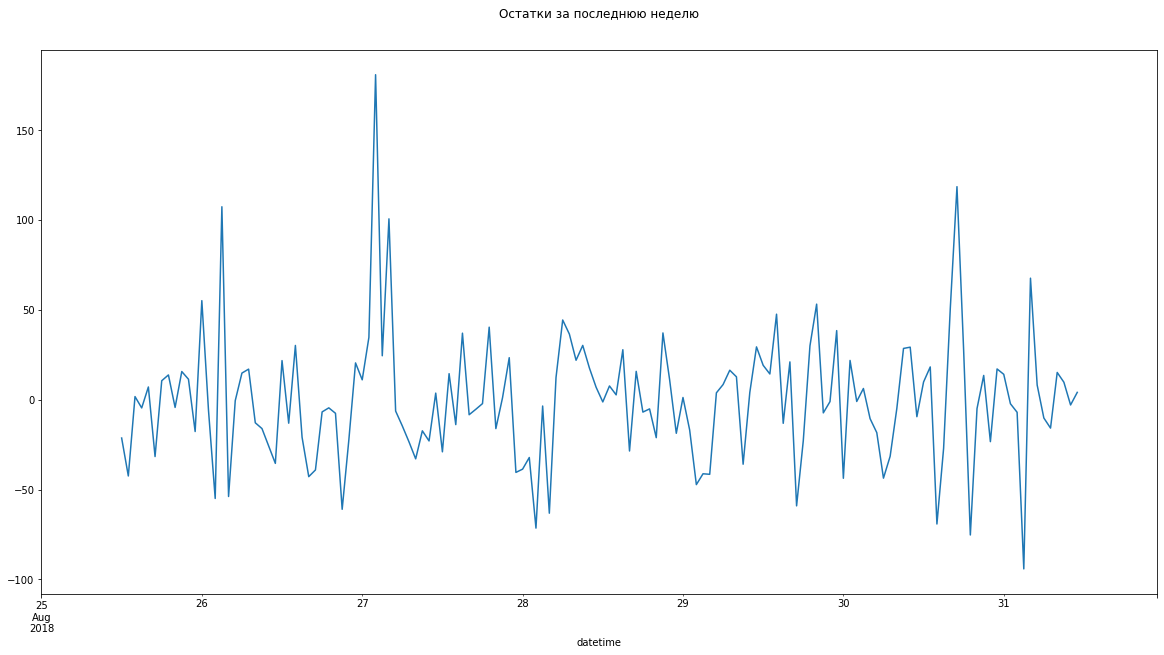

In [12]:
decomposed_df_week.resid.plot(figsize=figsize)
plt.title('Остатки за последнюю неделю', y=1.05)

Ресемплируем ряд по дню и выведем последний месяц.

In [13]:
df_day = df.resample('1D').sum()

<AxesSubplot:xlabel='datetime'>

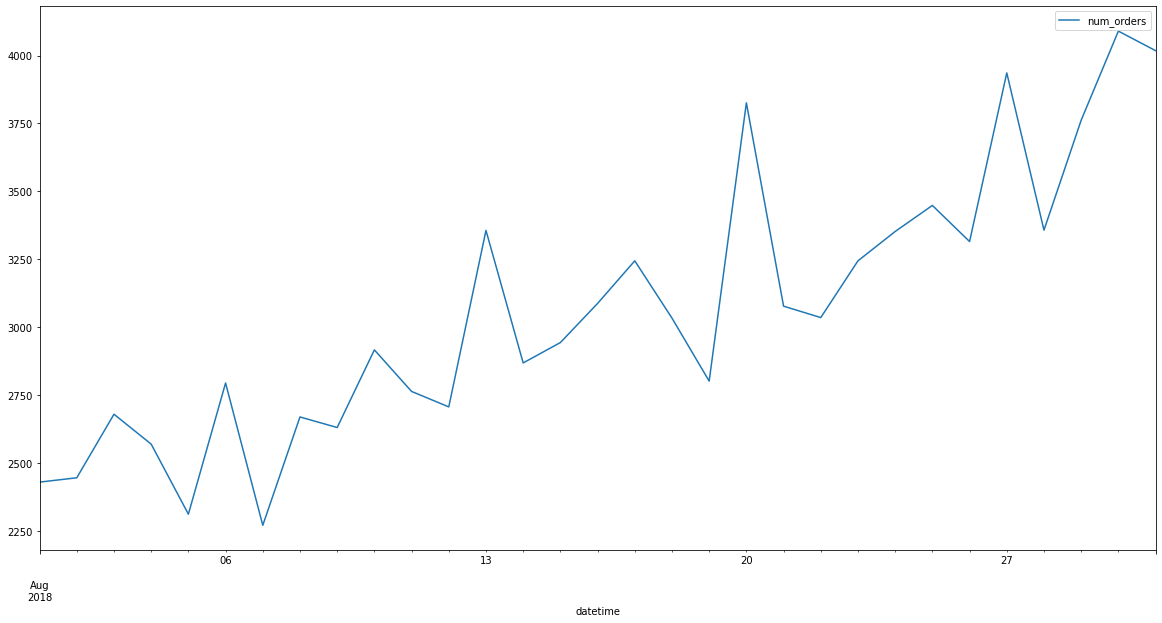

In [14]:
df_day['2018-08-01':'2018-08-31'].plot(figsize=figsize)

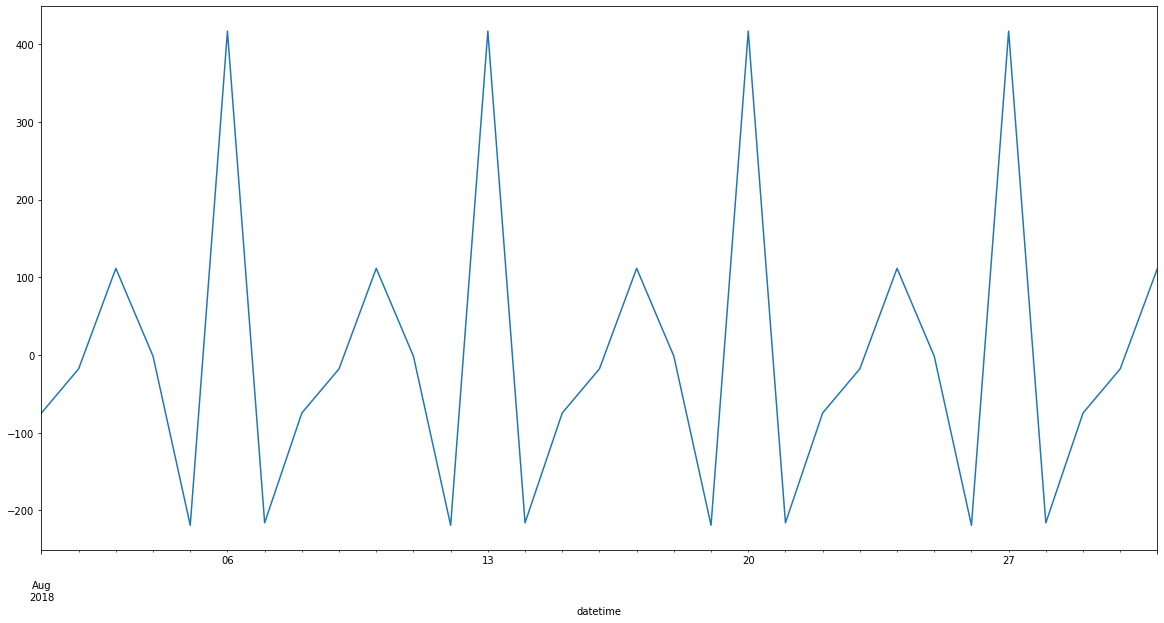

In [17]:
decomposed_df_day = seasonal_decompose(df_day['2018-08-01':'2018-08-31'])
decomposed_df_day.seasonal.plot(figsize=figsize);

Как мы видим присутствует сезонность внутри недели.

Смотрим как меняется среднее и стандартное отклонение, а также взглянем на стационарный временной ряд

<AxesSubplot:xlabel='datetime'>

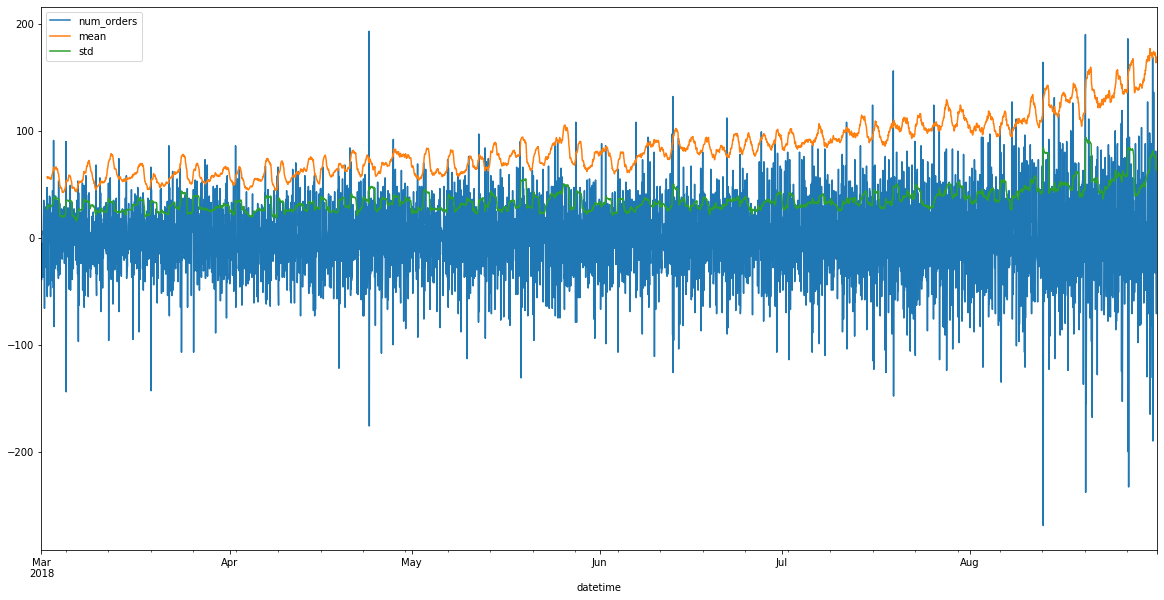

In [15]:
df_shift = df - df.shift()
df_shift['mean'] = df['num_orders'].rolling(24).mean()
df_shift['std'] = df['num_orders'].rolling(24).std()
df_shift.plot(figsize=figsize)

In [16]:
result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] < 0.05:
    print('Временной ряд стационарен')
else:
    print('Временной ряд не стационарен')

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Временной ряд стационарен


### Вывод по временным рядам

* Кол-во заказов растет - то есть растет тренд
* Остатки не коррелируют и нормально распределены
* Временной ряд не является стационарным, так как меняется среднее значение
* Присутствует сезонность в течении дня, недельная сезонность

Пишем функции для расчета RMSE и визуализации данных обученных моделей

In [17]:
def rmse(target, predicted):
    return mean_squared_error(target, predicted) ** 0.5

In [18]:
def illustration(test,predict):
    rmse = mean_squared_error(test,predict)
    mae = mean_absolute_error(test,predict)
    plt.figure(figsize=(10, 5))
    pd.Series(predict).hist(bins=50, alpha=0.8)
    pd.Series(test).hist(bins=50, alpha=0.8)
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(10, 10))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-500,500)
    plt.ylim(-100,500)
    plt.plot([-500,500],[-500,500],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Создаем признаки и цель для обучения и тестирования

In [19]:
max_lag = 24
rolling_mean_size = 24
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [20]:
df = df.copy()

make_features(df,'num_orders', max_lag, rolling_mean_size)
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=RND_ST)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
display(features_train)
display(target_train)

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,9,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,134.041667
2018-08-13 10:00:00,10,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,135.250000
2018-08-13 11:00:00,11,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,137.250000


datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3950, dtype: int64

## Обучение

Статичная модель на обучающей выборке

MAE: 29.711645569620252
RMSE: 38.833872073914605


/tmp/ipykernel_62/222712441.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


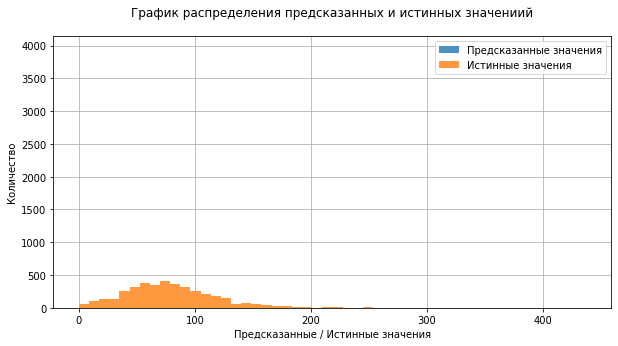

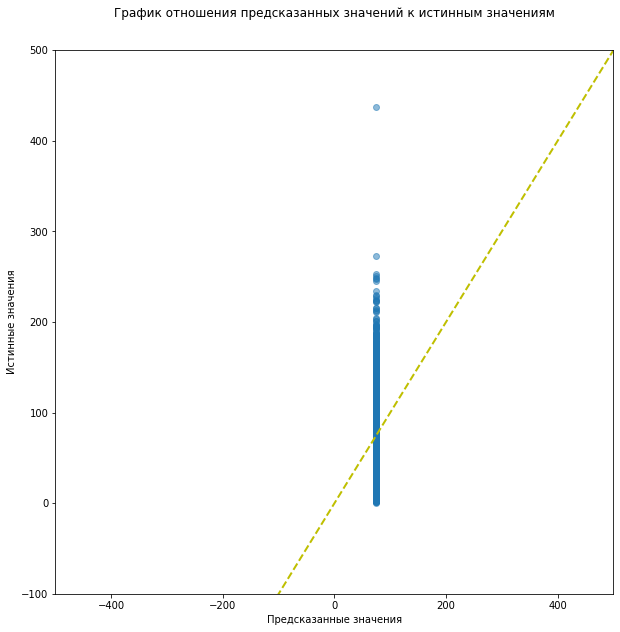

CPU times: user 574 ms, sys: 34.9 ms, total: 609 ms
Wall time: 617 ms


In [21]:
%%time

model_test = DummyRegressor(strategy = "median")
model_test.fit(features_train, target_train)
predict_test = model_test.predict(features_train)
mae_test = mean_absolute_error(target_train, predict_test)
rmse_test = rmse(target_train, predict_test)
print('MAE:',mae_test)
print('RMSE:',rmse_test)
illustration(target_train, predict_test)

ElasticNet на обучающей выборке

In [22]:
tscv = TimeSeriesSplit(n_splits=2)

In [23]:
%%time

parameters_2 = {'alpha': np.arange(0.1, 1.0, 0.1), 'l1_ratio': np.arange(0.1, 1.0, 0.1)}

model_2_test = ElasticNet(random_state = RND_ST)
grid_2 = GridSearchCV(estimator=model_2_test, cv=tscv,
                        param_grid=parameters_2)
grid_2.fit(features_train, target_train)

grid_2.best_params_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357095.78306099446, tolerance: 293.58235975702354
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261114.29459231836, tolerance: 293.58235975702354
  model = cd_fast.enet_coordinate_descent(


CPU times: user 18.8 s, sys: 26 s, total: 44.8 s
Wall time: 44.9 s


{'alpha': 0.9, 'l1_ratio': 0.9}

MAE: 19.57446253608784
RMSE: 25.8451836727194


/tmp/ipykernel_62/222712441.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


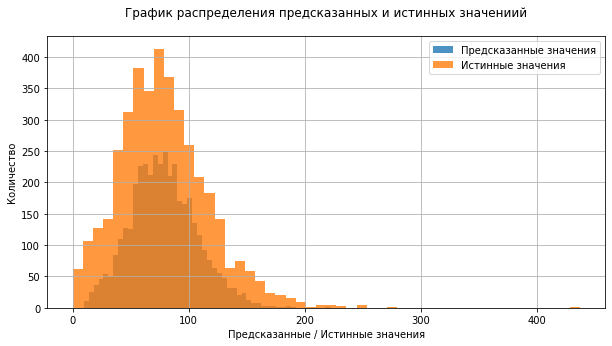

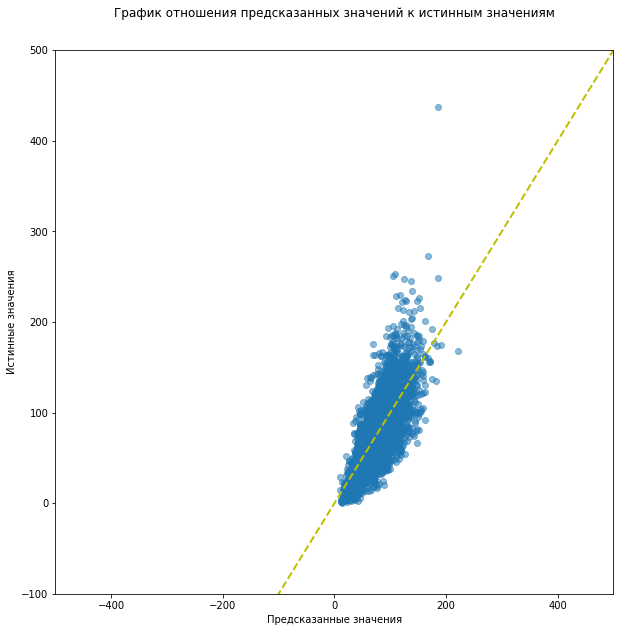

CPU times: user 761 ms, sys: 210 ms, total: 972 ms
Wall time: 1.01 s


In [24]:
%%time

model_2 = ElasticNet(random_state = RND_ST, **grid_2.best_params_)
model_2.fit(features_train, target_train)
predict_2 = model_2.predict(features_train)
mae_2 = mean_absolute_error(target_train, predict_2)
rmse_2 = rmse(target_train, predict_2)
print('MAE:',mae_2)
print('RMSE:',rmse_2)
illustration(target_train, predict_2)

LGBMRegressor на обучающей выборке

In [25]:
%%time

parameters_3 = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 101, 20), 'num_leaves': range(20, 51, 10)}

model_3_test=LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse')
grid_3=GridSearchCV(model_3_test, parameters_3, scoring='neg_mean_squared_error')
grid_3.fit(features_train, target_train)

grid_3.best_params_

CPU times: user 4h 14min 25s, sys: 2min 9s, total: 4h 16min 35s
Wall time: 4h 18min 1s


{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 20}

MAE: 12.612015956898079
RMSE: 16.37357832168594


/tmp/ipykernel_62/222712441.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


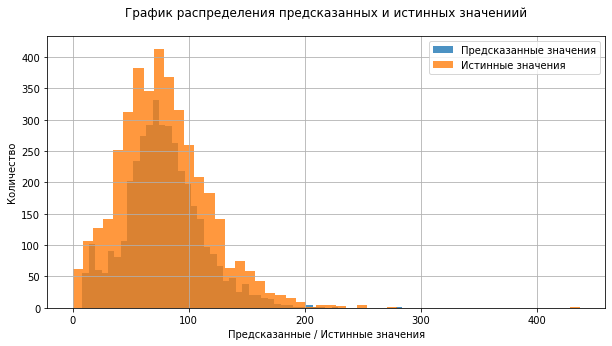

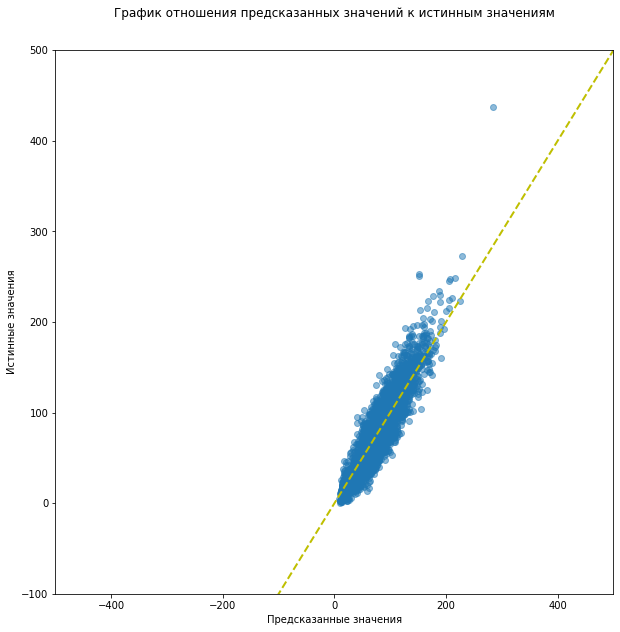

CPU times: user 945 ms, sys: 30.2 ms, total: 975 ms
Wall time: 998 ms


In [26]:
%%time

model_3 = LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse', **grid_3.best_params_)
model_3.fit(features_train, target_train)
predict_3 = model_3.predict(features_train)
mae_3 = mean_absolute_error(target_train, predict_3)
rmse_3 = rmse(target_train, predict_3)
print('MAE:',mae_3)
print('RMSE:',rmse_3)
illustration(target_train, predict_3)

### Вывод
Все модели прошли порог RMSE = 48. Результаты:
* DummyRegressor: RMSE = 38.83
* ElasticNet: RMSE = 25.84
* LGBMRegressor: RMSE = 16.37 <br />

Возьмем модель LGBMRegressor, как показавшую себя лучше всего 

## Тестирование

LGBMRegressor на тестовой выборке

MAE: 32.43902091706572
RMSE: 43.53167027732204


/tmp/ipykernel_62/222712441.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


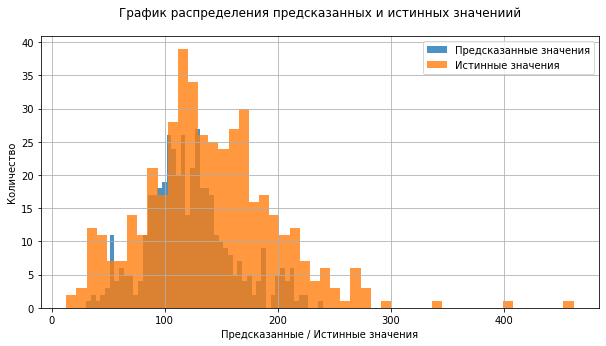

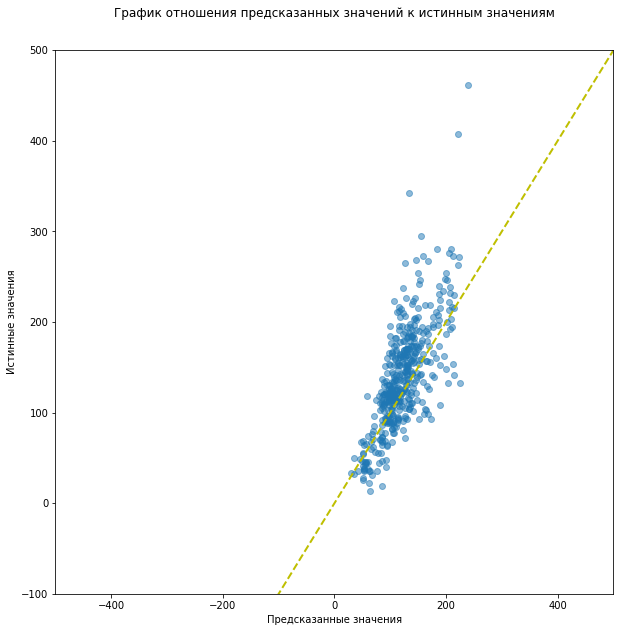

CPU times: user 1.09 s, sys: 26.3 ms, total: 1.12 s
Wall time: 1.14 s


In [27]:
%%time

model_3_test = LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse', **grid_3.best_params_)
model_3_test.fit(features_train, target_train)
predict_3_test = model_3_test.predict(features_test)
mae_3_test = mean_absolute_error(target_test, predict_3_test)
rmse_3_test = rmse(target_test, predict_3_test)
print('MAE:',mae_3_test)
print('RMSE:',rmse_3_test)
illustration(target_test, predict_3_test)

### Общий вывод
Результат лучшей модели LGBMRegressor на тестовой выборке: RMSE: 43.53. Что удовлетворяет поставленному условию.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48